# Paleotemperatures with SIMMAX 

In [1]:
from pangaeapy import PanDataSet
import math
import sys
import pandas as pd
analogDS = PanDataSet('10.1594/PANGAEA.77352')
sampleDS=PanDataSet('10.1594/PANGAEA.55156')
#The annual mean
#levitus=pd.read_csv('woa13_decav_t00mn01v2.csv',sep=';')
#summer
levitus=pd.read_csv('woa13_decav_t15mn01.csv',sep=';')

#Compare with:
#http://discovery.ucl.ac.uk/101363/1/2002PA000774.pdf

In [2]:
def getLevitusTemp(lat, lon, lev):
    depth=30
    t=0
    #select the values for the upper water column
    temp=lev[['0','5','10','15','20','25','30','35','40','45','50']][(lev['LATITUDE']== (math.floor(lat)+0.5)) & (lev['LONGITUDE']== (math.floor(lon)+0.5))]
    #delete empty cells
    temp=temp.dropna(axis=1).to_dict(orient='list')
    #cast dict keys from string to int
    temp={int(key): value for key, value in temp.items()} 
    temp_keys=list(temp.keys())
    #find the closest available water depth value
    closest=min(temp_keys, key=lambda x:abs(x-depth))
    if len(temp[closest])>0:
        t=temp[closest][0]
        if t==None:
            print(str(lat)+' x '+str(lon))
            t=0
    else:
        print(str(lat)+' + '+str(lon))
        t=0
    return t
analogDS.data['Temperature']=analogDS.data.apply(lambda x: getLevitusTemp(x['Latitude'],x['Longitude'], levitus), axis=1)

83.4067 + 19.9717
82.7967 + 16.0683
43.8333 + -4.5
43.5498 + -2.0198
43.83 + -4.5
-35.2067 + -26.765
-35.2067 + -26.7633
28.255 + -13.395
34.8733 + -6.6333
34.8917 + -6.6717
34.56 + -6.7583
34.92 + -6.845
34.9283 + -6.925
84.0292 + 11.2383
-23.35 + -16.53
-24.07 + -15.12
-2.0667 + -40.6


In [3]:
sampleDS.data[(sampleDS.data['Event']=='GIK16458-1')].head()

,Campaign,Event,Latitude,Longitude,Date/Time,Elevation,Depth,G. aequilateralis,G. bulloides,D. grahami,...,G. tenellus,G. truncatulinoides s,G. truncatulinoides d,G. truncatulinoides,G. tumida,O. universa,G. uvula,G. mentum,P/D int_2,N. pachyderma d
2,ANT-IV/1c,GIK16458-1,5.335,-22.0533,1985-10-22,-3518,0.24,3.9,6.4,0.0,...,0.0,0.0,0.0,6.4,3.8,1.1,0.0,3.8,0.8,2.5
3,ANT-IV/1c,GIK16458-1,5.335,-22.0533,1985-10-22,-3518,0.26,1.5,2.6,0.3,...,0.5,0.0,0.0,1.3,0.0,0.9,0.0,0.0,0.0,1.0
4,ANT-IV/1c,GIK16458-1,5.335,-22.0533,1985-10-22,-3518,0.28,1.8,4.5,0.0,...,0.0,0.0,0.0,2.0,0.0,1.4,0.0,0.0,0.0,0.8
5,ANT-IV/1c,GIK16458-1,5.335,-22.0533,1985-10-22,-3518,0.30,2.2,4.5,0.0,...,0.0,0.0,0.0,2.5,0.0,0.8,0.0,0.0,0.7,1.4


In [4]:
#Sometimes the dataset also contains data from different depths of one event, we simplify the procedure here a bit and remove event duplicates e.g. deeper samples
sampleDS.data.drop_duplicates(subset='Event', keep='first', inplace=True)
sampleDS.data[(sampleDS.data['Event']=='GIK16458-1')].head()

,Campaign,Event,Latitude,Longitude,Date/Time,Elevation,Depth,G. aequilateralis,G. bulloides,D. grahami,...,G. tenellus,G. truncatulinoides s,G. truncatulinoides d,G. truncatulinoides,G. tumida,O. universa,G. uvula,G. mentum,P/D int_2,N. pachyderma d
2,ANT-IV/1c,GIK16458-1,5.335,-22.0533,1985-10-22,-3518,0.24,3.9,6.4,0.0,...,0.0,0.0,0.0,6.4,3.8,1.1,0.0,3.8,0.8,2.5


In [5]:
def getDistance(row):
    
    R = 6372800  # Earth radius in meters
    lat1, lon1 = row['Latitude1'], row['Longitude1']
    lat2, lon2 = row['Latitude2'], row['Longitude2']
    
    phi1, phi2 = math.radians(lat1), math.radians(lat2) 
    dphi       = math.radians(lat2 - lat1)
    dlambda    = math.radians(lon2 - lon1)
    
    a = math.sin(dphi/2)**2 + \
        math.cos(phi1)*math.cos(phi2)*math.sin(dlambda/2)**2
    
    return 2*R*math.atan2(math.sqrt(a), math.sqrt(1 - a))/1000
#Remove duplicates

#Merge to receive a sampl x analog matrix
Distances = pd.merge(sampleDS.data[['Event','Latitude','Longitude', 'Depth']].assign(k=1), analogDS.data[['Event','Latitude','Longitude','Temperature']].assign(k=1), on='k', suffixes=('1', '2')).drop('k', axis=1)
Distances['Event1']=Distances['Event1']+'_'+Distances['Depth'].map(str)
Distances['Distance']=Distances.apply(getDistance, axis=1)
#But we need to avoid to run into a division by zero trap, preperae by the simmean algo which will snap if distance is zero: (sj/dj)
#Therefore we need to replace zero distances by a very, very low distance e.g. 0.000000001 m or so
Distances.loc[Distances['Distance']==0,'Distance']=0.00000000001
Distances.set_index(['Event1', 'Event2'], inplace=True)  

In [6]:
Distances.head()  

Latitude1  Longitude1  Depth  Latitude2  Longitude2  \
Event1       Event2                                                          
A180-73_0.38 A152-84      0.1667       -23.0   0.38    44.3498    -30.2670   
             A153-154     0.1667       -23.0   0.38    28.0000    -38.7830   
             A164-13      0.1667       -23.0   0.38    35.7167    -67.3333   
             A164-15      0.1667       -23.0   0.38    36.1333    -68.9167   
             A164-16      0.1667       -23.0   0.38    36.1500    -69.1500   

                       Temperature     Distance  
Event1       Event2                              
A180-73_0.38 A152-84        17.747  4966.625659  
             A153-154       25.440  3523.320635  
             A164-13        25.755  6048.173979  
             A164-15        26.113  6194.765676  
             A164-16        26.006  6213.920072

In [7]:
#Forams used by Pflaumann et. al in SIMMAX28
#G. mentum = Globorotalia cultrata and tumida
foramCols=[]
foramParams=['G. bulloides','G. calida','G. falconensis','G. quinqueloba','G. rubescens','G. digitata','G. aequilateralis',
             'G. conglobatus','G. ruber p','G. ruber w', 'G. tenellus','G. trilobus tril','G. trilobus sac','O. universa',
             'S. dehiscens','G. crassaformis','G. mentum', 'G. hirsuta', 'G. inflata', 'G. scitula','G. truncatulinoides',
             'N. dutertrei','N. pachyderma s','P/D int','G. glutinata','P. obliquiloculata']

for fP in foramParams:
    if fP in sampleDS.data.columns:
        foramCols.append(fP)

In [8]:
#Lets do the SIMMAX
import numpy as np
#sum of squared percentages 
sampleDS.data['SQRTSUM']=np.sqrt((sampleDS.data[foramCols]**2).sum(axis=1))
analogDS.data['SQRTSUM']=np.sqrt((analogDS.data[foramCols]**2).sum(axis=1))
sampleIdx=sampleDS.data[foramCols].div(sampleDS.data['SQRTSUM'], axis=0)
analogIdx=analogDS.data[foramCols].div(analogDS.data['SQRTSUM'], axis=0)
sampleIdx['Event']=sampleDS.data['Event']+'_'+sampleDS.data['Depth'].map(str)
sampleIdx.set_index('Event', inplace=True)
analogIdx['Event']=analogDS.data['Event']
analogIdx.set_index('Event', inplace=True)
SimIndex = pd.DataFrame(
    (analogIdx[foramCols].values * sampleIdx[foramCols].values[:, None]).reshape(-1, analogIdx.shape[1]),
    pd.MultiIndex.from_product([sampleIdx.index, analogIdx.index]),
   sampleIdx.columns
)
Similars=pd.DataFrame(SimIndex.sum(axis=1), columns=['Similarity'])
Similars['Distance']=Distances['Distance']
Similars['Latitude']=Distances['Latitude1']
Similars['Longitude']=Distances['Longitude1']
Similars['Temperature']=Distances['Temperature']

In [9]:

#s=Similars.loc['PS1231-2'].sort_values(['Similarity'],ascending=False)
#s[s['Similarity']>=0.999]
s=Similars[Similars['Similarity']>=0.999]

In [10]:
#Original SIMMAX is using those values with similarity index >0.79 only
#mostSimilars=Similars.loc[(Similars['Similarity']>=0.79)]
#The revised SIMMAX is using the 10 top most similars with sim inded >0.9
mostSimilars=Similars[Similars['Similarity']>=0.9].sort_values(by='Similarity',ascending=False).groupby(level=0).head(10).sort_index(level=0,sort_remaining=False)
mostSimilars.index.names=['sampleEvent', 'analogEvent']  
mostSimilars

Similarity      Distance  Latitude  Longitude  \
sampleEvent  analogEvent                                                  
A180-73_0.38 GeoB1716-2     0.906310   5032.816437    0.1667   -23.0000   
BOFS14K_0.34 V27-23         0.999832   2079.700524   58.6288   -19.4349   
             PS1707-1       0.999823   1575.227844   58.6288   -19.4349   
             RC13-275       0.999819  12522.234683   58.6288   -19.4349   
             V23-63         0.999802   2267.604919   58.6288   -19.4349   
             RC11-78        0.999781  12210.073765   58.6288   -19.4349   
             RC11-79        0.999774  12047.427837   58.6288   -19.4349   
             V17-192        0.999769   1632.530389   58.6288   -19.4349   
             V27-25         0.999750   2083.128491   58.6288   -19.4349   
             PS2627-5       0.999746   1620.402796   58.6288   -19.4349   
             V29-215        0.999736   2007.176977   58.6288   -19.4349   
BOFS17K_0.68 GIK23483-2     0.999483   1101.625831   58.0010   -16.5014   
             RC13-275       0.999299  12396.008150   58.0010   -16.5014   
             V23-63         0.999246   2304.440322   58.0010   -16.5014   
             GIK23270-2     0.999169   1820.597089   58.0010   -16.5014   
             GIK23295-4     0.999148   1539.466870   58.0010   -16.5014   
             PS1707-1       0.999106   1629.946857   58.0010   -16.5014   
             GIK23294-3     0.998993   1621.018583   58.0010   -16.5014   
             V27-23         0.998965   2256.137310   58.0010   -16.5014   
             GIK23511-2     0.998951   1693.469518   58.0010   -16.5014   
             PS1229-1       0.998944   2276.981778   58.0010   -16.5014   
BOFS5K_0.78  GIK23371-1     0.999987   2421.441866   50.6876   -21.8635   
             PS1706-1       0.999983   2678.155049   50.6876   -21.8635   
             GIK23293-1     0.999974   2551.966998   50.6876   -21.8635   
             GIK23369-1     0.999973   2420.153006   50.6876   -21.8635   
             GIK23370-1     0.999972   2420.444170   50.6876   -21.8635   
             GIK23295-2     0.999969   2421.836761   50.6876   -21.8635   
             PS2616-7       0.999968   2786.175037   50.6876   -21.8635   
             GIK23512-1     0.999964   2508.897944   50.6876   -21.8635   
             PS1296-3       0.999962   3172.846263   50.6876   -21.8635   
...                              ...           ...       ...        ...   
V28-56_0.6   V28-25         0.999999    989.251200   68.0330    -6.1170   
             V28-22         0.999997    564.575400   68.0330    -6.1170   
             V27-56         0.999993    905.030435   68.0330    -6.1170   
             OD-041-04      0.999991   1819.717123   68.0330    -6.1170   
             V27-24         0.999987   2826.357324   68.0330    -6.1170   
             GIK23489-2     0.999979    274.887596   68.0330    -6.1170   
             V28-37         0.999965    462.272559   68.0330    -6.1170   
             V16-227        0.999964   2288.694798   68.0330    -6.1170   
             GIK23400-1     0.999961    484.329242   68.0330    -6.1170   
             V28-36         0.999958    280.992209   68.0330    -6.1170   
V29-179_0.87 SU90-17        0.972057   2109.407112   44.0170   -24.5300   
             V27-38         0.969783   2111.156830   44.0170   -24.5300   
             SU90-20        0.968170   2034.258285   44.0170   -24.5300   
             SU90-I05       0.960185   2109.326661   44.0170   -24.5300   
             V27-30         0.949359   2022.456039   44.0170   -24.5300   
             V27-40         0.939212   2456.836340   44.0170   -24.5300   
             GIK23073-2     0.931686   3066.851337   44.0170   -24.5300   
             GIK23467-2     0.930836   2780.044328   44.0170   -24.5300   
             GIK23068-2     0.930272   3054.473128   44.0170   -24.5300   
             RC12-235       0.929092  10888.268151   44.0170   -24.5300   
V30-49_0.6   GIK13534-1     0.979474    441.489451 

In [11]:
analogDS.data[analogDS.data['Event'].isin(['V27-23','PS1707-1','RC13-275','RC11-79'])]

,Campaign,Event,Latitude,Longitude,Date/Time,Elevation,Depth,G. aequilateralis,G. bulloides,G. calida,...,O. universa,G. uvula,G. mentum,P/D int_2,N. pachyderma d,Foram plankt oth,Foram plankt,Sample comment,Temperature,SQRTSUM
66,ARK-V/2,PS1707-1,72.6166,-13.8400,1988-07-30,-2118,0,0.0,1.1,0.0,...,0.0,0.0,0.0,0.0,1.5,0.0,543,Uwe Pflaumann,0.740,96.720422
600,RC11,RC11-79,-49.0000,-4.6000,1967-02-20,-3385,0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.3,2.3,0.8,385,CLIMAP Project Members,4.333,94.844293
626,RC13,RC13-275,-50.7167,13.4333,NaT,-1984,0,0.0,0.9,0.0,...,0.0,0.0,0.0,0.0,1.8,1.4,326,CLIMAP Project Members,1.726,92.947942
822,V27,V27-23,54.7330,-53.1200,1969-07-04,-830,0,0.0,0.4,0.0,...,0.0,0.0,0.0,0.8,0.8,0.4,252,CLIMAP Project Members,2.137,96.416596


In [12]:
#Paleotemperature calculations following Pflaumann's Formula (3)
PaleoTemp=pd.DataFrame()
PaleoTemp['TEMP']=((mostSimilars['Temperature']*mostSimilars['Similarity']/ mostSimilars['Distance']).groupby(level=0).sum())/((mostSimilars['Similarity']/mostSimilars['Distance']).groupby(level=0).sum())

PaleoTemp['LAT']=mostSimilars.groupby(level=0)['Latitude'].max()
PaleoTemp['LON']=mostSimilars.groupby(level=0)['Longitude'].max()

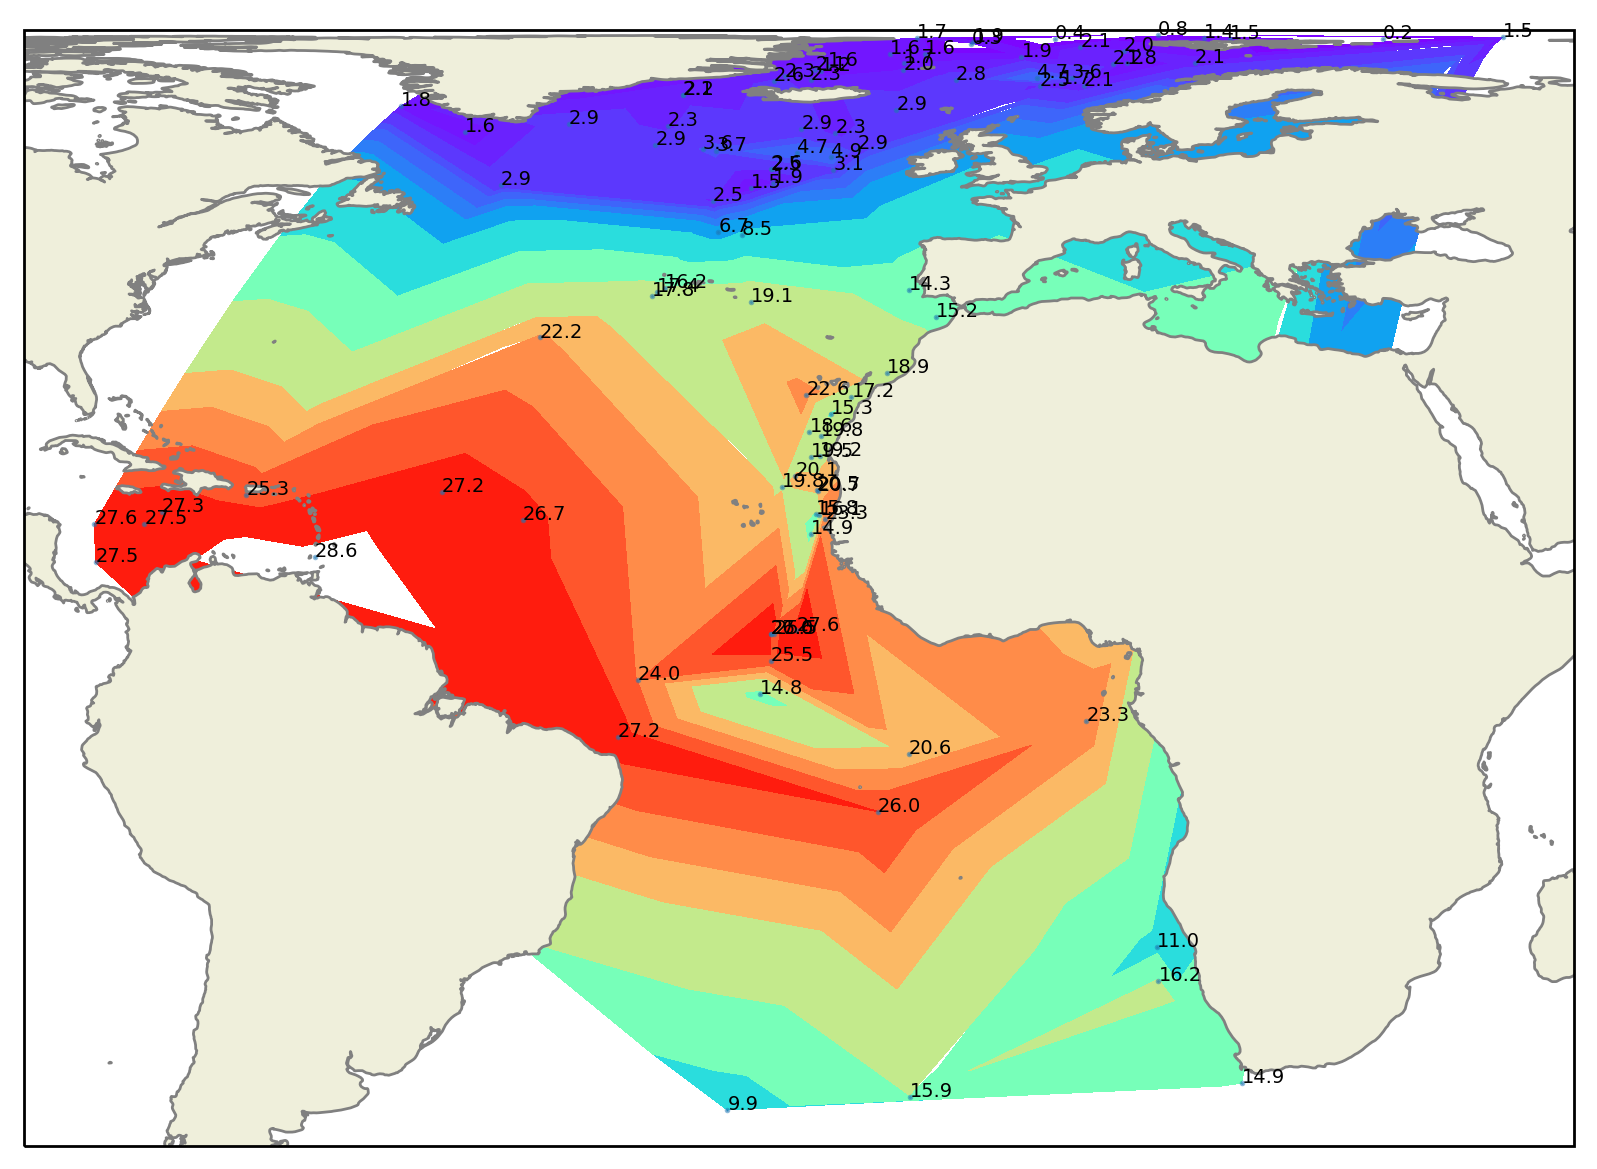

In [19]:
import cartopy.crs as ccrs
import cartopy.feature as feat
import matplotlib.pyplot as plt
proj=ccrs.LambertCylindrical()
plt.figure(figsize=(10,10),dpi=200)
ax = plt.axes(projection=proj)
land_50m = feat.NaturalEarthFeature('physical', 'land', '50m',edgecolor='grey',facecolor=feat.COLORS['land'])

#PaleoTemp = PaleoTemp[np.isfinite(PaleoTemp['TEMP'])]
#print(PaleoTemp)

ax.tricontourf(PaleoTemp['LON'],PaleoTemp['LAT'], PaleoTemp['TEMP'],levels=[1,1.5,2,2.5,3.5,4,5,6,8,12,16,20,22,24,26,28],cmap = "rainbow",transform=ccrs.Geodetic())
ax.add_feature(land_50m)
ax.scatter(PaleoTemp['LON'],PaleoTemp['LAT'],label=None, alpha=0.5, s=1,cmap = "rainbow",transform=ccrs.Geodetic())

for i, point in PaleoTemp.iterrows():
        ax.text(point['LON'], point['LAT'], str(point['TEMP'].round(1)),fontsize=7, transform=ccrs.Geodetic())

## References:

In [15]:
print(analogDS.citation)
print()
print(sampleDS.citation)

Pflaumann, Uwe; Sarnthein, Michael; Chapman, Mark R; de Abreu, Lucia; Funnell, Brian M; Hüls, Matthias; Kiefer, Thorsten; Maslin, Mark A; Prahl, Frederick G; Swallow, John; van Kreveld, Shirley A; Vautravers, Maryline J; Vogelsang, Elke; Weinelt, Mara (2003): Distribution of planktic foraminifera in surface sediments of the Atlantic Ocean (ATL947). PANGAEA, https://doi.org/10.1594/PANGAEA.77352, In supplement to: Pflaumann, Uwe; Sarnthein, Michael; Chapman, Mark R; de Abreu, Lucia; Funnell, Brian M; Hüls, Matthias; Kiefer, Thorsten; Maslin, Mark A; Schulz, Hartmut; Swallow, John; van Kreveld, Shirley A; Vautravers, Maryline J; Vogelsang, Elke; Weinelt, Mara (2003): Glacial North Atlantic: Sea-surface conditions reconstructed by GLAMAP 2000. Paleoceanography, 18(3), 1065, https://doi.org/10.1029/2002PA000774

Pflaumann, Uwe; Sarnthein, Michael; Chapman, Mark R; de Abreu, Lucia; Funnell, Brian M; Hüls, Matthias; Kiefer, Thorsten; Maslin, Mark A; Prahl, Frederick G; Swallow, John; van Kre